In [4]:
using Gen
using Distributions
using Random
using Plots
using Statistics

## Model

In [5]:
@gen function chain_particle_decay_model(T::Int, delta_t::Float64)
    lambda1 ~ gamma(3, 0.02)   # decay rate - isotope 1
    lambda2 ~ gamma(3, 0.007)  # decay rate - isotope 2
    N1_0 ~ normal(10000, 3000) # population - isotope 1

    # Initial populations and trajectories
    N1 = N1_0
    N2 = 0.0
    N1_trajectory = Float64[N1]
    N2_trajectory = Float64[N2]
    observations = Float64[]
    
    for t in 1:T
        # Expected decays at timestep t follow Poisson(lambda)
        decays1 = N1 * (1 - exp(-lambda1 * delta_t))
        decays2 = N2 * (1 - exp(-lambda2 * delta_t))       
        
        # Update populations
        N1 = max(N1 - decays1, 0.0)
        N2 = max(N2 + decays1 - decays2, 0.0)
        push!(N1_trajectory, N1)
        push!(N2_trajectory, N2)
        
        # Add the decay observation
        expected = decays1 + decays2
        obs = @trace(normal(expected, 4.0), (:obs, t)) # some noise!
        push!(observations, obs)
    end
    
    return (observations, N1_trajectory, N2_trajectory)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing], Main.var"##chain_particle_decay_model#277", Bool[0, 0], false)

In [ ]:
Random.seed!(420) # change this for a different dist
T = 200        
dt = 1.0

(trace, _) = generate(chain_particle_decay_model, (T, dt))
(observations, N1_trajectory, N2_trajectory) = get_retval(trace)

println("Observed particle decay counts (every 20th):")
println(round.(observations[1:20:end], digits=2))

println("\nLatent parameters:")
println("l1 = ", round(trace[:lambda1], digits=3))
println("l2 = ", round(trace[:lambda2], digits=3))
println("N1(0) = ", round(trace[:N1_0], digits=0), " atoms")

Observed particle decay counts (every 20th):
[689.1, 360.01, 213.88, 143.1, 102.04, 73.3, 43.42, 41.21, 24.29, 23.61]

Latent parameters:
λ1 = 0.051
λ2 = 0.015
N1(0) = 13758.0 atoms


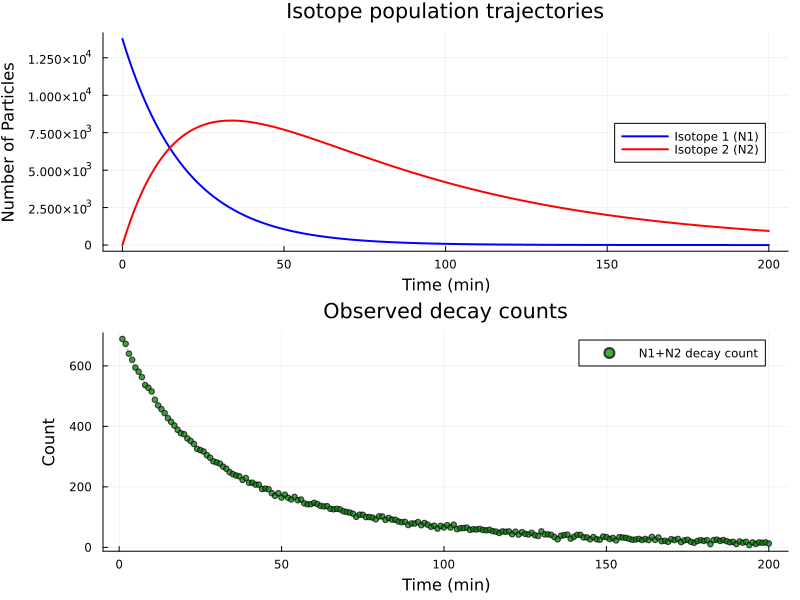

In [7]:
time_full = 0:dt:(T*dt)
time_obs = dt:dt:(T*dt)

# Population trajectories
p1 = plot(time_full, N1_trajectory, 
    label="Isotope 1 (N1)", lw=2, color=:blue,
    xlabel="Time (min)", ylabel="Number of Particles",
    title="Isotope population trajectories",
    legend=:right)
plot!(p1, time_full, N2_trajectory, label="Isotope 2 (N2)", lw=2, color=:red)

# Observed decay counts
p2 = scatter(time_obs, observations, 
    label="N1+N2 decay count", ms=3, alpha=0.7, color=:green,
    xlabel="Time (min)", ylabel="Count",
    title="Observed decay counts")
plot!(p2, time_obs, observations, alpha=0.3, color=:green, label="")

plot(p1, p2, layout=(2,1), size=(800, 600))

In [ ]:
# Extract true parameters from trace for comparison
true_lambda1 = trace[:lambda1]
true_lambda2 = trace[:lambda2]
true_N1_0 = trace[:N1_0]

# Create observation constraints for inference
obs_constraints = choicemap()
for t in 1:T
    obs_constraints[(:obs, t)] = observations[t]
end

println("True parameters extracted:")
println("l1 = $true_lambda1")
println("l2 = $true_lambda2")
println("N1(0) = $true_N1_0")

True parameters extracted:
λ1 = 0.05133495122287637
λ2 = 0.015193361218020519
N1(0) = 13758.477283104196


## Baselines

In [ ]:
# Baseline - MH (averaged over 20 runs)
n_runs = 20
n_iters = 100
param_sel = select(:lambda1, :lambda2, :N1_0)

mh_lambda1_runs = Float64[]
mh_lambda2_runs = Float64[]
mh_N1_0_runs = Float64[]
mh_acceptance_runs = Float64[]

for run in 1:n_runs
    current_trace, _ = generate(chain_particle_decay_model, (T, dt), obs_constraints)
    mh_samples = Vector{Tuple{Float64, Float64, Float64}}()
    accepted = 0

    for i in 1:n_iters
        current_trace, acc = mh(current_trace, param_sel)
        accepted += acc
        push!(mh_samples, (current_trace[:lambda1], current_trace[:lambda2], current_trace[:N1_0]))
    end

    push!(mh_lambda1_runs, mean(first.(mh_samples)))
    push!(mh_lambda2_runs, mean(getindex.(mh_samples, 2)))
    push!(mh_N1_0_runs, mean(last.(mh_samples)))
    push!(mh_acceptance_runs, accepted/n_iters)
end

mh_lambda1 = mean(mh_lambda1_runs)
mh_lambda2 = mean(mh_lambda2_runs)
mh_N1_0 = mean(mh_N1_0_runs)
mh_acceptance = mean(mh_acceptance_runs)

println("\n" * "="^50)
println("MH RESULTS (averaged over $n_runs runs)")
println("="^50)
println("Acceptance rate: $(round(100*mh_acceptance, digits=1))%")
println()
println("Parameter    Estimate    Std         True        Error")
println("-"^60)
println("l1           $(round(mh_lambda1, digits=4))      $(round(std(mh_lambda1_runs), digits=4))      $(round(true_lambda1, digits=4))      $(round(abs(mh_lambda1 - true_lambda1), digits=4))")
println("l2           $(round(mh_lambda2, digits=4))      $(round(std(mh_lambda2_runs), digits=4))      $(round(true_lambda2, digits=4))      $(round(abs(mh_lambda2 - true_lambda2), digits=4))")
println("N1(0)        $(round(mh_N1_0, digits=1))    $(round(std(mh_N1_0_runs), digits=1))    $(round(true_N1_0, digits=1))    $(round(abs(mh_N1_0 - true_N1_0), digits=1))")

Run 5/20 completed
Run 10/20 completed
Run 15/20 completed
Run 20/20 completed

MH RESULTS (averaged over 20 runs)
Acceptance rate: 4.2%

Parameter    Estimate    Std         True        Error
------------------------------------------------------------
λ1           0.0537      0.004      0.0513      0.0024
λ2           0.0185      0.0046      0.0152      0.0033
N1(0)        12930.3    752.1    13758.5    828.2


In [ ]:
# Baseline - IS (averaged over 20 runs)
n_runs = 20
n_samples = 100

is_lambda1_runs = Float64[]
is_lambda2_runs = Float64[]
is_N1_0_runs = Float64[]
is_ess_runs = Float64[]

for run in 1:n_runs
    is_traces = []
    log_weights = Float64[]

    for i in 1:n_samples
        tr, _ = generate(chain_particle_decay_model, (T, dt))
        tr, w, _, _ = update(tr, (T, dt), (NoChange(), NoChange()), obs_constraints)
        push!(is_traces, tr)
        push!(log_weights, w)
    end

    # Normalize weights
    weights = exp.(log_weights .- maximum(log_weights))
    weights ./= sum(weights)
    ess = 1.0 / sum(weights.^2)

    push!(is_lambda1_runs, sum(weights .* [s[:lambda1] for s in is_traces]))
    push!(is_lambda2_runs, sum(weights .* [s[:lambda2] for s in is_traces]))
    push!(is_N1_0_runs, sum(weights .* [s[:N1_0] for s in is_traces]))
    push!(is_ess_runs, ess)
end

is_lambda1 = mean(is_lambda1_runs)
is_lambda2 = mean(is_lambda2_runs)
is_N1_0 = mean(is_N1_0_runs)
is_ess = mean(is_ess_runs)

println("==================================================")
println("IMPORTANCE SAMPLING RESULTS (averaged over $n_runs runs)")
println("==================================================")
println("ESS: $(round(is_ess, digits=1)) / $n_samples")
println("Parameter    Estimate    Std         True        Error")
println("--------------------------------------------------")
println("l1           $(round(is_lambda1, digits=4))      $(round(std(is_lambda1_runs), digits=4))      $(round(true_lambda1, digits=4))      $(round(abs(is_lambda1 - true_lambda1), digits=4))")
println("l2           $(round(is_lambda2, digits=4))      $(round(std(is_lambda2_runs), digits=4))      $(round(true_lambda2, digits=4))      $(round(abs(is_lambda2 - true_lambda2), digits=4))")
println("N1(0)        $(round(is_N1_0, digits=1))    $(round(std(is_N1_0_runs), digits=1))    $(round(true_N1_0, digits=1))    $(round(abs(is_N1_0 - true_N1_0), digits=1))")

Run 5/20 completed
Run 10/20 completed
Run 15/20 completed
Run 20/20 completed

IMPORTANCE SAMPLING RESULTS (averaged over 20 runs)
ESS: 1.0 / 100

Parameter    Estimate    Std         True        Error
------------------------------------------------------------
λ1           0.0525      0.0058      0.0513      0.0012
λ2           0.017      0.0042      0.0152      0.0018
N1(0)        13470.8    1115.9    13758.5    287.7


## Custom

In [ ]:
sel_lambda1 = select(:lambda1)
sel_lambda2 = select(:lambda2)
sel_N1_0 = select(:N1_0)

n_runs = 20
n_burnin = 100 
n_sample = 100 

custom_lambda1_runs = Float64[]
custom_lambda2_runs = Float64[]
custom_N1_0_runs = Float64[]
custom_acceptance_runs = Float64[]

println("Running Componentwise MH...")
println("Config: burn-in=$n_burnin, samples=$n_sample, 3 params updated per iter")

for run in 1:n_runs
    current_trace, _ = generate(chain_particle_decay_model, (T, dt), obs_constraints)
    
    samples = Vector{Tuple{Float64, Float64, Float64}}()
    total_accepted = 0
    total_proposed = 0
    
    for i in 1:(n_burnin + n_sample)
        # Componentwise updates using Gen's built-in MH
        # Each update proposes from the prior for that single parameter
        current_trace, acc1 = mh(current_trace, sel_lambda1)
        current_trace, acc2 = mh(current_trace, sel_lambda2)
        current_trace, acc3 = mh(current_trace, sel_N1_0)
        
        total_accepted += acc1 + acc2 + acc3
        total_proposed += 3
        
        # Collect samples after burn-in
        if i > n_burnin
            push!(samples, (current_trace[:lambda1], current_trace[:lambda2], current_trace[:N1_0]))
        end
    end
    
    push!(custom_lambda1_runs, mean(first.(samples)))
    push!(custom_lambda2_runs, mean(getindex.(samples, 2)))
    push!(custom_N1_0_runs, mean(last.(samples)))
    push!(custom_acceptance_runs, total_accepted / total_proposed)
    
    run % 5 == 0 && println("Run $run/$n_runs completed")
end

custom_lambda1 = mean(custom_lambda1_runs)
custom_lambda2 = mean(custom_lambda2_runs)
custom_N1_0 = mean(custom_N1_0_runs)
custom_acceptance = mean(custom_acceptance_runs)

println("\n" * "="^50)
println("CUSTOM MH RESULTS (averaged over $n_runs runs)")
println("="^50)
println("Acceptance rate: $(round(100*custom_acceptance, digits=1))%")
println()
println("Parameter    Estimate    Std         True        Error")
println("-"^60)
println("l1           $(round(custom_lambda1, digits=4))      $(round(std(custom_lambda1_runs), digits=4))      $(round(true_lambda1, digits=4))      $(round(abs(custom_lambda1 - true_lambda1), digits=4))")
println("l2           $(round(custom_lambda2, digits=4))      $(round(std(custom_lambda2_runs), digits=4))      $(round(true_lambda2, digits=4))      $(round(abs(custom_lambda2 - true_lambda2), digits=4))")
println("N1(0)        $(round(custom_N1_0, digits=1))    $(round(std(custom_N1_0_runs), digits=1))    $(round(true_N1_0, digits=1))    $(round(abs(custom_N1_0 - true_N1_0), digits=1))")

Running Componentwise MH...
Config: burn-in=100, samples=100, 3 params updated per iter
Run 5/20 completed
Run 10/20 completed
Run 15/20 completed
Run 20/20 completed

CUSTOM MH RESULTS (averaged over 20 runs)
Acceptance rate: 3.5%

Parameter    Estimate    Std         True        Error
------------------------------------------------------------
λ1           0.0516      0.0021      0.0513      0.0003
λ2           0.0154      0.002      0.0152      0.0002
N1(0)        13732.2    615.8    13758.5    26.3


## Comparison

In [ ]:
mh_total_err = abs(mh_lambda1-true_lambda1)/true_lambda1 + abs(mh_lambda2-true_lambda2)/true_lambda2 + abs(mh_N1_0-true_N1_0)/true_N1_0
is_total_err = abs(is_lambda1-true_lambda1)/true_lambda1 + abs(is_lambda2-true_lambda2)/true_lambda2 + abs(is_N1_0-true_N1_0)/true_N1_0
custom_total_err = abs(custom_lambda1-true_lambda1)/true_lambda1 + abs(custom_lambda2-true_lambda2)/true_lambda2 + abs(custom_N1_0-true_N1_0)/true_N1_0

println("\n" * "="^70)
println("COMPARISON SUMMARY (averaged over 20 runs each)")
println("="^70)
println()
println("True values:")
println("  l1 = $(round(true_lambda1, digits=4))")
println("  l2 = $(round(true_lambda2, digits=4))")
println("  N1(0) = $(round(true_N1_0, digits=1))")
println()
println("Method              l1 error (±std)      l2 error (±std)      N1(0) error (±std)")
println("-"^70)
println("MH (joint)          $(round(abs(mh_lambda1-true_lambda1), digits=4)) (±$(round(std(mh_lambda1_runs), digits=4)))    $(round(abs(mh_lambda2-true_lambda2), digits=4)) (±$(round(std(mh_lambda2_runs), digits=4)))    $(round(abs(mh_N1_0-true_N1_0), digits=1)) (±$(round(std(mh_N1_0_runs), digits=1)))")
println("IS                  $(round(abs(is_lambda1-true_lambda1), digits=4)) (±$(round(std(is_lambda1_runs), digits=4)))    $(round(abs(is_lambda2-true_lambda2), digits=4)) (±$(round(std(is_lambda2_runs), digits=4)))    $(round(abs(is_N1_0-true_N1_0), digits=1)) (±$(round(std(is_N1_0_runs), digits=1)))")
println("Custom (comp.)      $(round(abs(custom_lambda1-true_lambda1), digits=4)) (±$(round(std(custom_lambda1_runs), digits=4)))    $(round(abs(custom_lambda2-true_lambda2), digits=4)) (±$(round(std(custom_lambda2_runs), digits=4)))    $(round(abs(custom_N1_0-true_N1_0), digits=1)) (±$(round(std(custom_N1_0_runs), digits=1)))")
println()
println("Total Relative Error:")
println("  MH (joint):     $(round(100*mh_total_err, digits=1))%")
println("  IS:             $(round(100*is_total_err, digits=1))%")
println("  Custom (comp.): $(round(100*custom_total_err, digits=1))%")
println()

best_err = min(mh_total_err, is_total_err, custom_total_err)
if custom_total_err == best_err
    println("🏆 Custom componentwise MH wins!")
    println("   $(round(mh_total_err/custom_total_err, digits=1))x better than MH (joint)")
    println("   $(round(is_total_err/custom_total_err, digits=1))x better than IS")
end


COMPARISON SUMMARY (averaged over 20 runs each)

True values:
  λ1 = 0.0513
  λ2 = 0.0152
  N1(0) = 13758.5

Method              λ1 error (±std)      λ2 error (±std)      N1(0) error (±std)
----------------------------------------------------------------------
MH (joint)          0.0024 (±0.004)    0.0033 (±0.0046)    828.2 (±752.1)
IS                  0.0012 (±0.0058)    0.0018 (±0.0042)    287.7 (±1115.9)
Custom (comp.)      0.0003 (±0.0021)    0.0002 (±0.002)    26.3 (±615.8)

Total Relative Error:
  MH (joint):     32.5%
  IS:             16.0%
  Custom (comp.): 2.1%

🏆 Custom componentwise MH wins!
   15.3x better than MH (joint)
   7.5x better than IS
